In [77]:
# Chem 277B: Machine Learning Algorithms for
#            Molecular Sciences
#
# Date Created: 12/11/2024
# Last revisited: 12/12/2024



In [78]:
# imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nrsim_lstm import NRSIM_LSTM as lstm
import sys
import Archive.utils277b as utils


In [79]:
# load data

filepath="Simulation Data/Sim_only_small_fuel_element_failure"
data = pd.read_csv(filepath)


data.head()

,Time,pH,Hydrogen,Total Gas,Temperature,Pressure,Radioactivity,Power,Reactor Safety,Injection of Air,Injection of Air Degree,Resin Overheat,Resin Overheat Degree,Fuel Element Failure,Fuel Element Failure Degree,Chemical Addition,Vent Gas
0,0,11.000,50.000000,60.000000,500.000000,2100.000000,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,1,10.998,50.112998,60.112998,500.732703,2104.971916,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,2,10.996,50.225941,60.225941,501.463398,2109.930204,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,3,10.994,50.338517,60.338517,502.190083,2114.861274,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
4,4,10.992,50.450414,60.450414,502.910764,2119.751611,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [80]:

# Organizing the dataframe


numerical = ['Time', 'pH', 'Hydrogen', 'Total Gas', 'Temperature', 'Pressure','Radioactivity', 'Power']
categorical = ['Reactor Safety', 'Injection of Air', 'Injection of Air Degree', 
               'Resin Overheat', 'Resin Overheat Degree', 'Fuel Element Failure', 
               'Fuel Element Failure Degree', 'Chemical Addition', 'Vent Gas']


# In case there are NaN values (representing false for reactor condiditon)
data = data.fillna(False)
data[categorical] = data[categorical].astype(int)


# making sure NaN values are filled
unique_values = data.apply(pd.Series.unique)
print(unique_values)

Time                           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
pH                             [11.0, 10.998, 10.996, 10.993999999999998, 10....
Hydrogen                       [50.0, 50.11299808734272, 50.22594112618216, 5...
Total Gas                      [60.0, 60.11299808734272, 60.22594112618216, 6...
Temperature                    [500.0, 500.7327033874012, 501.4633984857471, ...
Pressure                       [2100.0, 2104.97191584308, 2109.930204010427, ...
Radioactivity                  [10.0, 13.0, 16.0, 19.0, 22.0, 25.0, 28.0, 31....
Power                                                                    [100.0]
Reactor Safety                                                            [0, 1]
Injection of Air                                                             [0]
Injection of Air Degree                                                      [0]
Resin Overheat                                                               [0]
Resin Overheat Degree       

In [81]:

# setting up training data

npast_timesteps = 50
nfuture_timesteps = 35
nfeatures_past = len(numerical) - 1
npredfeatures = nfeatures_past

X = np.array(data[numerical].drop(columns=["Time"]))
Y = np.array(data[numerical].drop(columns=["Time"]))

scalerY, Y_norm = utils.scale(Y)
scalerX, X_norm = utils.scale(X)

[X, _] = utils.prep_lstm_data(X_norm, npast_timesteps, nfuture_timesteps)
[_, Y] = utils.prep_lstm_data(Y_norm, npast_timesteps, nfuture_timesteps)

print(X.shape, Y.shape)

(4237, 50, 7) (4237, 35, 7)


In [82]:
# train test split
cut = int(np.round(0.7*Y.shape[0]))

TrainX, TrainY = X[:cut], Y[:cut]
TestX, TestY = X[cut:], Y[cut:]


In [83]:
# setting up actual model (for parameter prediction)


classification=False


# because we are using a CNN layer this 
# input reshape must be performed

TrainXreshape = TrainX.reshape((TrainX.shape[0], 1, TrainX.shape[1], TrainX.shape[2]))



# stacked lstm layers
neurons = [32, 32]
activation = "tanh"

# temporal params
n_past_timesteps = TrainX.shape[1]
n_features = TrainX.shape[2]
n_predicted_timesteps = TrainY.shape[1]
n_predicted_features = TrainY.shape[2]

# optimization + metrics
optimizer = "adam"
loss = "mse"
metrics =["mse", "mae"]

# convolutional layer
conv_layer = True
nfilters = 64  
conv_act = "relu" 
pool_size = 2  

# dropout
dropout = 0.2



my_model = lstm(
    neurons,
    activation,
    n_past_timesteps,
    n_features,
    n_predicted_timesteps,
    n_predicted_features,
    optimizer,
    loss,
    metrics,
    dropout,
    conv_layer,
    nfilters,
    conv_act,
    pool_size,
    classification
)

In [84]:
# fitting model on training data

n_epochs = 100
batch_size = 64


my_model.fit(TrainXreshape, TrainY, nEpochs=n_epochs, nBatches=batch_size, 
             val_split=0.2, verb=2, shuf=False)


# model history

out = my_model.get_model().history

Epoch 1/100
38/38 - 1s - 37ms/step - loss: 0.2014 - mae: 0.3418 - mse: 0.2014 - val_loss: 0.1034 - val_mae: 0.2537 - val_mse: 0.1034
Epoch 2/100
38/38 - 0s - 3ms/step - loss: 0.0878 - mae: 0.2368 - mse: 0.0878 - val_loss: 0.0761 - val_mae: 0.2281 - val_mse: 0.0761
Epoch 3/100
38/38 - 0s - 4ms/step - loss: 0.0722 - mae: 0.2162 - mse: 0.0722 - val_loss: 0.0688 - val_mae: 0.2165 - val_mse: 0.0688
Epoch 4/100
38/38 - 0s - 4ms/step - loss: 0.0602 - mae: 0.1966 - mse: 0.0602 - val_loss: 0.0598 - val_mae: 0.1988 - val_mse: 0.0598
Epoch 5/100
38/38 - 0s - 4ms/step - loss: 0.0540 - mae: 0.1841 - mse: 0.0540 - val_loss: 0.0566 - val_mae: 0.1905 - val_mse: 0.0566
Epoch 6/100
38/38 - 0s - 4ms/step - loss: 0.0506 - mae: 0.1766 - mse: 0.0506 - val_loss: 0.0549 - val_mae: 0.1853 - val_mse: 0.0549
Epoch 7/100
38/38 - 0s - 4ms/step - loss: 0.0480 - mae: 0.1710 - mse: 0.0480 - val_loss: 0.0526 - val_mae: 0.1809 - val_mse: 0.0526
Epoch 8/100
38/38 - 0s - 4ms/step - loss: 0.0459 - mae: 0.1665 - mse: 0.045

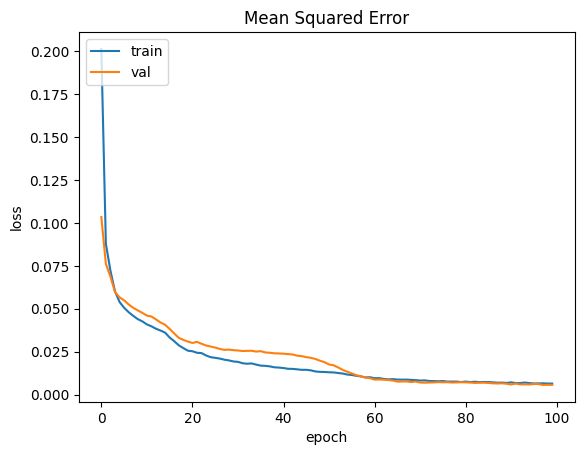

In [85]:
# plotting loss during training
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Mean Squared Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig(f"{filepath[16:]}_0.png")
plt.show()


In [86]:
# reshaping for testing data 
TestXreshape = TestX.reshape((TestX.shape[0], 1, TestX.shape[1], TestX.shape[2]))



# predicting outputs for test data
Y_pred_normalized = my_model.predict(TestXreshape)


# unscaling Y values
Y_pred_reshape = Y_pred_normalized.reshape(-1, npredfeatures)
Y_pred = scalerY.inverse_transform(Y_pred_reshape)

Y_pred = Y_pred.reshape(Y_pred_normalized.shape)



Y_pred.shape

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(1271, 35, 7)

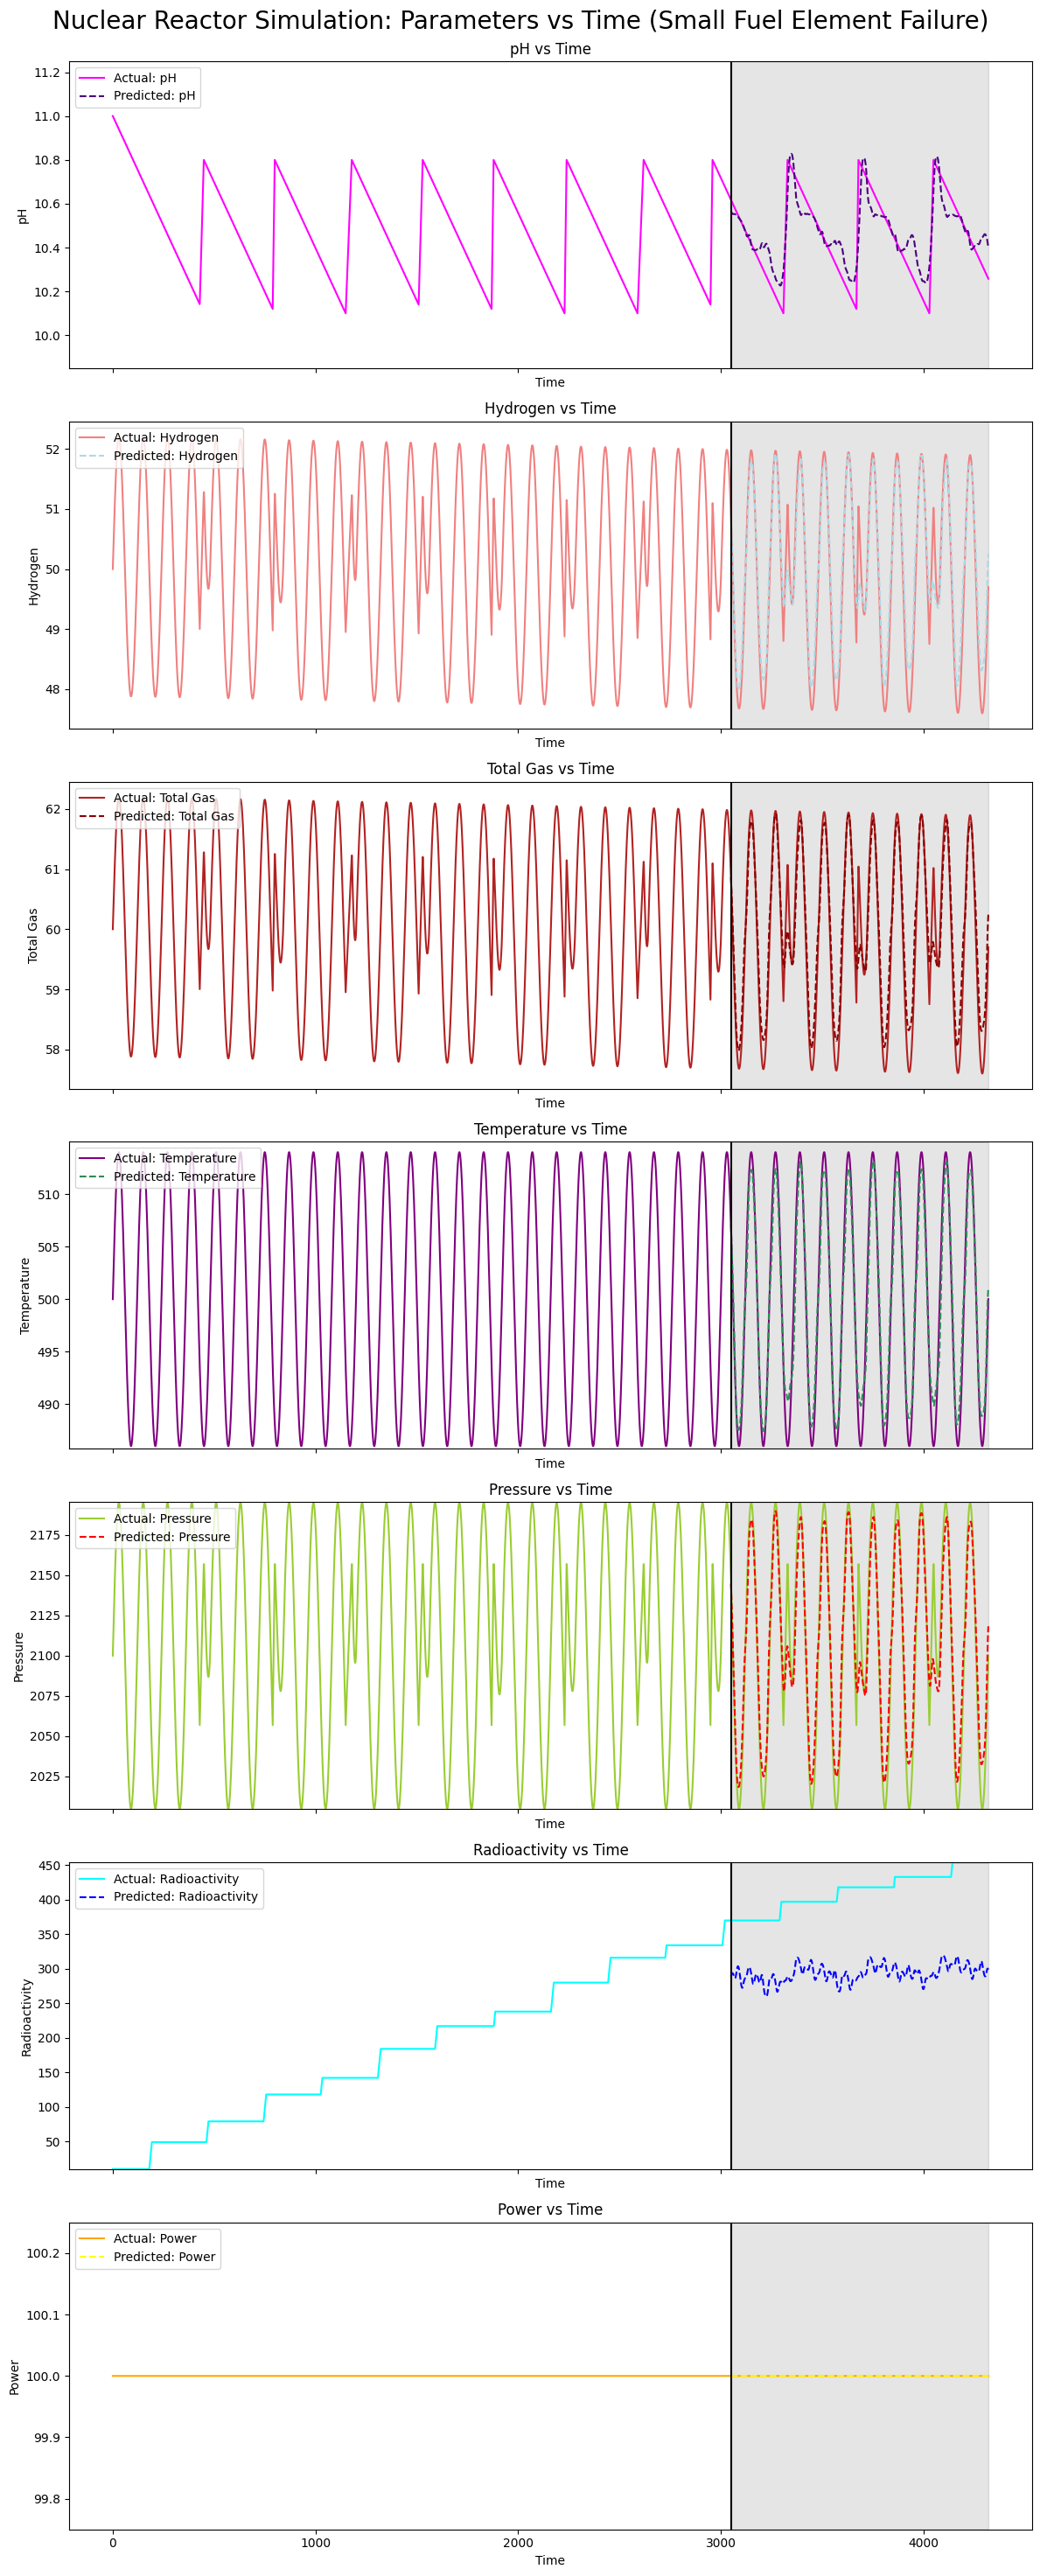

In [87]:




filepaths = {"Simulation Data/Sim_only_large_injection_of_air": "Large Injection of Air",
             "Simulation Data/Sim_No_Casualties": "No Casualties",
             "Simulation Data/Sim_only_large_fuel_element_failure": "Large Fuel Element Failure",
             "Simulation Data/Sim_only_large_resin_overheat": "Large Resin Overheat",
             "Simulation Data/Sim_only_small_fuel_element_failure": "Small Fuel Element Failure",
             "Simulation Data/Sim_only_small_injection_of_air": "Small Injection of Air",
             "Simulation Data/Sim_only_small_resin_overheat": "Small Resin Overheat"}







# Define target parameters and colors (7 colors for 7 parameters)
target_params = ["pH", 'Hydrogen', 'Total Gas', 'Temperature', 'Pressure', 'Radioactivity', 'Power']
color = ["magenta", "lightcoral", "firebrick", 
         "purple", "yellowgreen", "cyan", "orange"]  # Only 7 colors for 7 target parameters
color_2 = ["indigo", "lightblue",
         "darkred", "seagreen", "red", "blue", "yellow"]

# Reshape Time for plotting (ensure it's 1D for plotting)
t = data["Time"].values  # Original time values
t = t.flatten()  # Convert to 1D array

# Create a figure with subplots (one for each target parameter)
fig, axes = plt.subplots(len(target_params), 1, figsize=(12, 30), sharex=True)
fig.suptitle(f"Nuclear Reactor Simulation: Parameters vs Time ({filepaths[filepath]})", fontsize=20)

# Loop through each target parameter and create its subplot
for i, target_param in enumerate(target_params):
    ax = axes[i]  # Get the corresponding axis for the subplot

    # Actual data for each target parameter
    y_t = data[target_param].values
    y_t = y_t.flatten()  # Ensure y_t is 1D

    # Predicted data
    back = Y_pred.shape[0]
    Y_predfeat = Y_pred[:, :, i]


    # Setting bounds
    y_min = min(np.min(Y_predfeat), np.min(y_t)) 
    y_max = max(np.max(Y_predfeat), np.max(y_t))
    ax.set_ylim(y_min - 0.25, y_max + 0.25)

    # Plot data
    ax.plot(t, y_t, label=f"Actual: {target_param}", color=color[i])
    ax.plot(t[-back:], Y_predfeat[:, nfuture_timesteps-1], label=f"Predicted: {target_param}", linestyle='--', color=color_2[i])
    ax.fill_between(t[-back:], y_min-0.25, y_max+0.25, color='k', alpha=0.1)
    ax.plot([t[-back], t[-back]], [y_min-0.25, y_max+0.25], 'k-')
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{target_param}")
    ax.set_title(f"{target_param} vs Time")
    
    # Add a legend to each subplot
    ax.legend(loc='upper left')

# Adjust layout to prevent overlap and add spacing for titles/labels
plt.tight_layout()
plt.subplots_adjust(top=0.96)

plt.savefig(f"{filepath[16:]}_1.png")

# Show the final plot
plt.show()


In [88]:
import seaborn as sns

from sklearn.preprocessing import StandardScaler


df = pd.read_csv(filepath)
slice = df

df.iloc[3570:3580]

,Time,pH,Hydrogen,Total Gas,Temperature,Pressure,Radioactivity,Power,Reactor Safety,Injection of Air,Injection of Air Degree,Resin Overheat,Resin Overheat Degree,Fuel Element Failure,Fuel Element Failure Degree,Chemical Addition,Vent Gas
3570,3570,10.318,47.648238,57.648238,486.000000,2005.000000,397.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3571,3571,10.316,47.651058,57.651058,486.019187,2005.130194,397.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3572,3572,10.314,47.659510,57.659510,486.076693,2005.520420,397.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3573,3573,10.312,47.673574,57.673574,486.172363,2006.169608,400.0,100.0,0,NaN,NaN,NaN,NaN,True,True,False,False
3574,3574,10.310,47.693215,57.693215,486.305934,2007.075978,403.0,100.0,1,NaN,NaN,NaN,NaN,True,True,False,False
3575,3575,10.308,47.718385,57.718385,486.477038,2008.237047,406.0,100.0,1,NaN,NaN,NaN,NaN,True,True,False,False
3576,3576,10.306,47.749025,57.749025,486.685209,2009.649631,409.0,100.0,1,NaN,NaN,NaN,NaN,True,True,False,False
3577,3577,10.304,47.785058,57.785058,486.929874,2011.309859,412.0,100.0,1,NaN,NaN,NaN,NaN,True,True,False,False
3578,3578,10.302,47.826399,57.826399,487.210364,2013.213182,415.0,100.0,1,NaN,NaN,NaN,NaN,True,True,False,False
3579,3579,10.300,47.872947,57.872947,487.525909,2015.354380,418.0,100.0,1,NaN,NaN,NaN,NaN,True,True,False,False


In [89]:


scaler = StandardScaler()
num_data = slice[["pH", "Hydrogen", "Total Gas", "Temperature", "Pressure", "Radioactivity", "Power"]]
data_s = scaler.fit_transform(num_data)

data_s = pd.DataFrame(data_s, columns = num_data.columns, index = num_data.index)
data_s["Time"] = slice["Time"].values
data_s.head()

,pH,Hydrogen,Total Gas,Temperature,Pressure,Radioactivity,Power,Time
0,2.572742,-0.060994,-0.060994,0.000000,-0.153971,-1.801118,0.0,0
1,2.562983,0.019162,0.019162,0.074023,-0.073712,-1.801118,0.0,1
2,2.553224,0.099279,0.099279,0.147843,0.006328,-1.801118,0.0,2
3,2.543466,0.179136,0.179136,0.221257,0.085928,-1.801118,0.0,3
4,2.533707,0.258511,0.258511,0.294066,0.164871,-1.801118,0.0,4


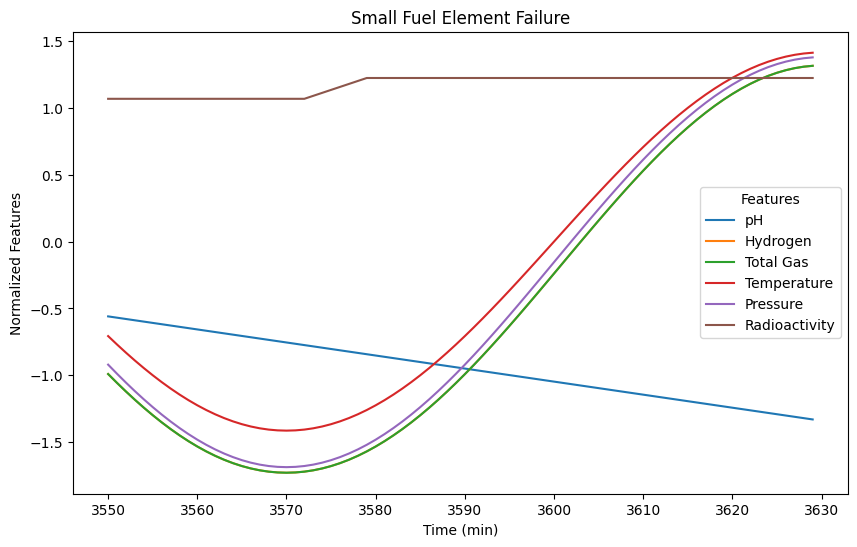

In [90]:
start_ts = 3550
end_ts = 3630


# Parameters over time
data_s.iloc[start_ts:end_ts].drop(columns="Power").plot(x = "Time", figsize = (10, 6))
plt.title(filepaths[filepath])
plt.xlabel("Time (min)")
plt.ylabel("Normalized Features")
plt.legend(title = "Features")
plt.savefig(f"{filepath[16:]}_2.png")
plt.show();

In [91]:
X2 = np.array(data_s.drop(columns="Time"))

X2[:5]

array([[ 2.57274179, -0.06099444, -0.06099444,  0.        , -0.1539712 ,
        -1.80111784,  0.        ],
       [ 2.56298306,  0.01916191,  0.01916191,  0.07402279, -0.07371168,
        -1.80111784,  0.        ],
       [ 2.55322433,  0.09927921,  0.09927921,  0.14784268,  0.00632786,
        -1.80111784,  0.        ],
       [ 2.5434656 ,  0.17913628,  0.17913628,  0.22125735,  0.08592803,
        -1.80111784,  0.        ],
       [ 2.53370687,  0.2585112 ,  0.2585112 ,  0.29406556,  0.16487065,
        -1.80111784,  0.        ]])

In [92]:
scalerX2, X2_norm = utils.scale(X2)

[X2, _] = utils.prep_lstm_data(X2_norm, npast_timesteps, nfuture_timesteps)
X2.shape


(4237, 50, 7)

In [93]:



X2 = X2[start_ts - 84:end_ts - 84]


X2 = X2.reshape((X2.shape[0], 1, X2.shape[1], X2.shape[2]))

X2.shape

(80, 1, 50, 7)

In [94]:
Y_norm = my_model.predict(X2)
Y_norm.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(80, 35, 7)

In [95]:

Y_pred= Y_norm[:, -1, :]


####
Y_pred = scalerY.inverse_transform(Y_pred)
Y_pred = scaler.fit_transform(Y_pred)


In [96]:
pred_df = pd.DataFrame(Y_pred, columns = ["predicted pH", "predicted Hydrogen", "predicted Total Gas", "predicted Temperature", "predicted Pressure", "predicted Radioactivity", "predicted Power"])

In [97]:
pred_df['Time'] = pred_df.index + start_ts

pred_df.head()

,predicted pH,predicted Hydrogen,predicted Total Gas,predicted Temperature,predicted Pressure,predicted Radioactivity,predicted Power,Time
0,0.604428,-0.408046,-0.407883,-0.411099,-0.410652,0.177560,0.0,3550
1,0.603158,-0.478125,-0.477785,-0.485521,-0.481214,0.158935,0.0,3551
2,0.609616,-0.544346,-0.543830,-0.554292,-0.547800,0.166534,0.0,3552
3,0.621244,-0.606516,-0.605872,-0.617115,-0.610165,0.206500,0.0,3553
4,0.643265,-0.665417,-0.664707,-0.674640,-0.669033,0.281046,0.0,3554


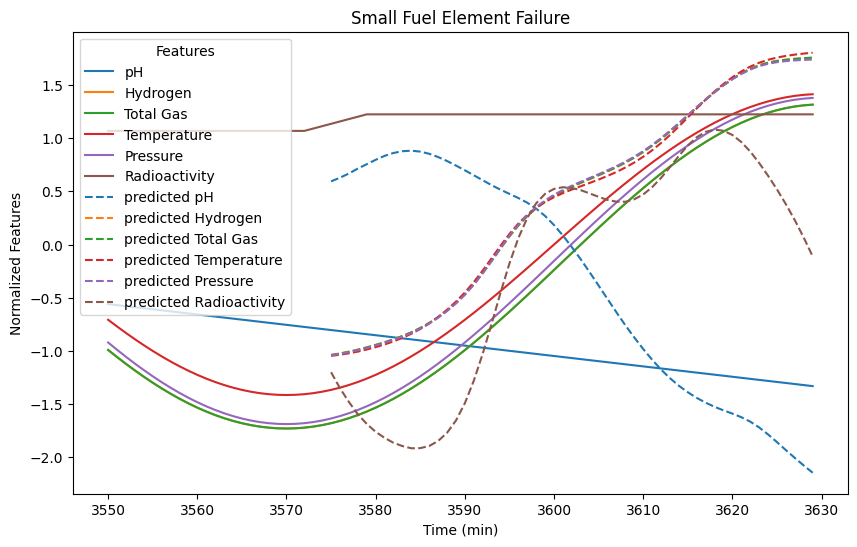

In [98]:
import matplotlib.pyplot as plt

pred_start_index = 25

filepaths = {"Simulation Data/Sim_only_large_injection_of_air": "Large Injection of Air",
             "Simulation Data/Sim_No_Casualties": "No Casualties",
             "Simulation Data/Sim_only_large_fuel_element_failure": "Large Fuel Element Failure",
             "Simulation Data/Sim_only_large_resin_overheat": "Large Resin Overheat",
             "Simulation Data/Sim_only_small_fuel_element_failure": "Small Fuel Element Failure",
             "Simulation Data/Sim_only_small_injection_of_air": "Small Injection of Air",
             "Simulation Data/Sim_only_small_resin_overheat": "Small Resin Overheat"}



# Create a single figure and axis for both plots
fig, ax = plt.subplots(figsize=(10, 6))

# Define a list of colors
colors = plt.cm.tab10.colors  # This gives a set of distinguishable colors

# Plot the normal features (solid lines)
data_s.iloc[start_ts:end_ts].drop(columns="Power").plot(x="Time", ax=ax, label='Normal Features', linestyle='-', color=colors)

# Plot the predicted features (dashed lines) with corresponding colors
pred_df.iloc[pred_start_index:].drop(columns="predicted Power").plot(x="Time", ax=ax, label='Predicted Features', linestyle='--', color=colors)

# Adding title and labels
plt.title(filepaths[filepath])
plt.xlabel("Time (min)")
plt.ylabel("Normalized Features")

# Add a legend to distinguish normal and predicted features
plt.legend(title="Features")

plt.savefig(f"{filepath[16:]}_3.png")

# Display the plot
plt.show()



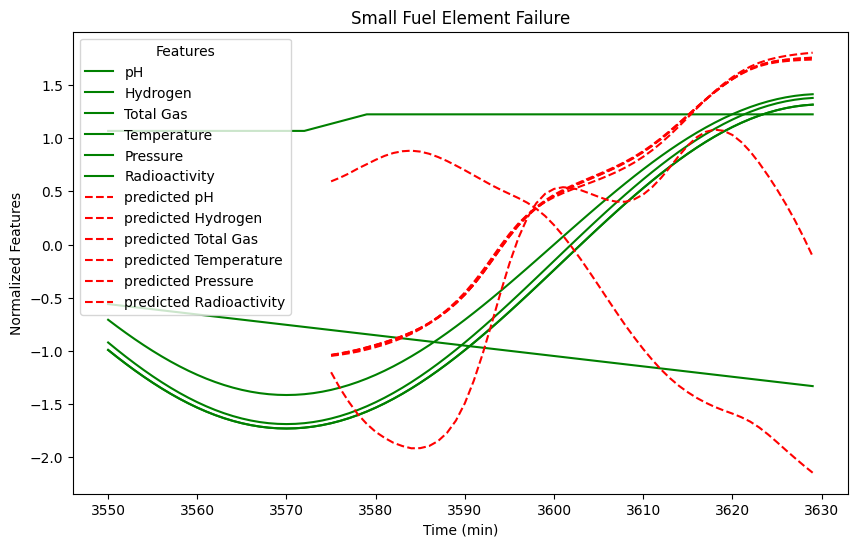

In [99]:
import matplotlib.pyplot as plt






# Create a single figure and axis for both plots
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab10.colors  

# features
data_s.iloc[start_ts:end_ts].drop(columns="Power").plot(x="Time", ax=ax, label='Normal Features', linestyle='-', color='g')
# predicted features
pred_df.iloc[pred_start_index:].drop(columns="predicted Power").plot(x="Time", ax=ax, label='Predicted Features', linestyle='--', color='r')

plt.title(filepaths[filepath])
plt.xlabel("Time (min)")
plt.ylabel("Normalized Features")
plt.legend(title="Features")

plt.savefig(f"{filepath[16:]}_4.png")
plt.show()

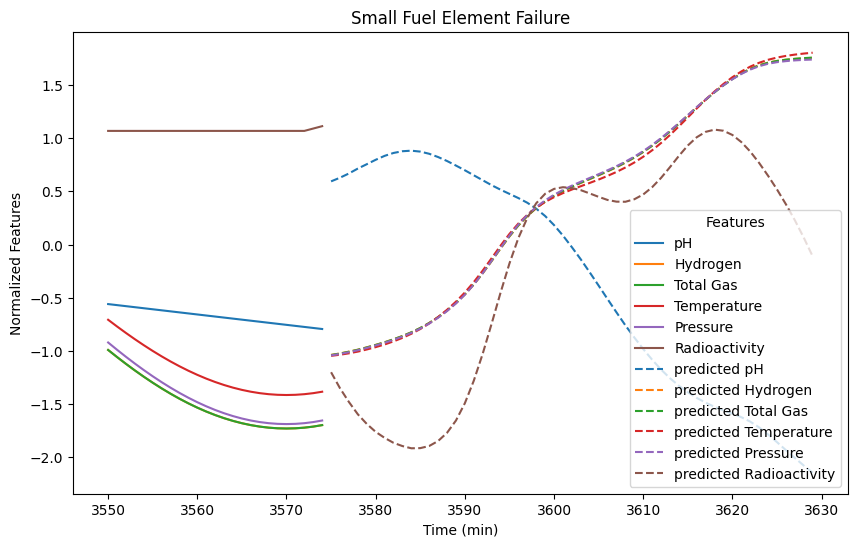

In [100]:
import matplotlib.pyplot as plt






# Create a single figure and axis for both plots
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab10.colors  

# features
data_s.iloc[start_ts:start_ts+pred_start_index].drop(columns="Power").plot(x="Time", ax=ax, label='Normal Features', linestyle='-', color=colors)
# predicted features
pred_df.iloc[pred_start_index:].drop(columns="predicted Power").plot(x="Time", ax=ax, label='Predicted Features', linestyle='--', color=colors)

plt.title(filepaths[filepath])
plt.xlabel("Time (min)")
plt.ylabel("Normalized Features")
plt.legend(title="Features")

plt.savefig(f"{filepath[16:]}_5.png")
plt.show()